# Advanced Deep Learning and Reinforcement Learning. Домашнее задание 1

## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру:
блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой
версии, которая реализована в OpenAI Gym:
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для
валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит
21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко,
если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
  * hit — взять ещё одну карту;
  * stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока
сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает
сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется
ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если
игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5
(полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py

In [1]:
import gym
env = gym.make('Blackjack-v0', natural=True)

### Задание 1

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках
комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit.
Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
class SimpleStrategy:
    def __call__(self, state, exploration):
        return state[0] < 19
    
    def update(self, state, new_state, action, reward):
        pass

In [3]:
from matplotlib import pyplot as plt

import numpy as np
import sys


class Pipeline:
    def evaluation_status(self, i, n):
        if (i + 1) % (n / 10) == 0:
            print("Calculation status: {} %.".format((i + 1) * 100 / n))
            sys.stdout.flush()
    
    def save_rewards(self, i, n):
        if (i + 1) % (n / 100) == 0:
            self.__training_rewards[i] = self.evaluate_reward(show_status=False)
            
    def plot_rewards(self):
        plt.plot(
            self.__training_rewards.keys(),
            self.__training_rewards.values(),
            label=type(self.strategy).__name__,
        )
        plt.xlabel('Episode')
        plt.ylabel('Average reward')
        plt.legend()
        plt.show()
    
    def __init__(self, env, strategy, seed=None):
        self.env = env
        self.strategy = strategy
        self.seed = seed or 42
        self.__training_rewards = {}
        
    def run_episode(self, learning=True):
        state = self.env.reset()
        states, actions, rewards = [state], [], [0]
        done = False
        while not done:
            action = self.strategy(state, learning)
            new_state, reward, done, info = self.env.step(action)
            if learning:
                self.strategy.update(state, new_state, action, reward)
            state = new_state
            states.append(state)
            actions.append(action)
            rewards.append(reward)
        return states, actions, rewards
    
    def reset(self):
        self.env.seed(self.seed)
        self.__training_rewards = {}
    
    def fit(self, show_status=True, save_rewards=True, total_episodes=200000):
        self.reset()
        for i in range(total_episodes):
            if show_status:
                self.evaluation_status(i, total_episodes)
            states, actions, rewards = self.run_episode(learning=True)
            if save_rewards:
                self.save_rewards(i, total_episodes) 
            
    def evaluate_reward(self, show_status=True, total_episodes=200000):
        total_reward = 0
        for i in range(total_episodes):
            if show_status:
                self.evaluation_status(i, total_episodes)
            _, _, rewards = self.run_episode(learning=False)
            total_reward += rewards[-1]
        return total_reward / total_episodes

In [4]:
pipeline = Pipeline(env, SimpleStrategy())
pipeline.evaluate_reward()

Calculation status: 10.0 %.
Calculation status: 20.0 %.
Calculation status: 30.0 %.
Calculation status: 40.0 %.
Calculation status: 50.0 %.
Calculation status: 60.0 %.
Calculation status: 70.0 %.
Calculation status: 80.0 %.
Calculation status: 90.0 %.
Calculation status: 100.0 %.


-0.17831

In [5]:
from collections import defaultdict


def first_visit_monte_carlo(pipeline, gamma=0.9, total_episodes=100000):
    ns = defaultdict(int)
    values = defaultdict(float)
    for i in range(total_episodes):
        pipeline.evaluation_status(i, total_episodes)
        states, _, rewards = pipeline.run_episode(learning=False)
        g = 0.0
        for t in range(len(states) - 1, -1, -1):
            r = rewards[t]
            g = gamma * g + r
            s = states[t]
            ns[s] += 1
            if s not in states[:t]:
                values[s] += (g - values[s]) / ns[s]
    return values

In [6]:
import pandas as pd


values = first_visit_monte_carlo(pipeline)
print(pd.DataFrame.from_dict(values, orient='index').sort_index())

Calculation status: 10.0 %.
Calculation status: 20.0 %.
Calculation status: 30.0 %.
Calculation status: 40.0 %.
Calculation status: 50.0 %.
Calculation status: 60.0 %.
Calculation status: 70.0 %.
Calculation status: 80.0 %.
Calculation status: 90.0 %.
Calculation status: 100.0 %.
                        0
(4, 1, False)   -0.461027
(4, 2, False)   -0.073040
(4, 3, False)   -0.312541
(4, 4, False)   -0.052889
(4, 5, False)   -0.299820
...                   ...
(28, 6, False)  -1.000000
(28, 7, False)  -1.000000
(28, 8, False)  -1.000000
(28, 9, False)  -1.000000
(28, 10, False) -1.000000

[350 rows x 1 columns]


### Задание 2

Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но
рекомендую попробовать и другие, например Monte Carlo control) для обучения
стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [7]:
from functools import partial


class QLearning:
    def __init__(self, env, alpha, eps, gamma):
        self.env = env
        
        self.__alpha = alpha
        self.__eps = eps
        self.__gamma = gamma
        
        self.__Q = defaultdict(partial(np.zeros, env.action_space.n, dtype=float))
        self.__pi = defaultdict(int)
        
    def __call__(self, state, exploration=True):
        if exploration and np.random.random() <= self.__eps:
            return np.random.randint(self.env.action_space.n)
        
        return self.__pi[state]
    
    def update(self, state, new_state, action, reward):
        self.__Q[state][action] += self.__alpha * (
            reward
            + self.__gamma * np.max(self.__Q[new_state])
            - self.__Q[state][action]
        )
        
        self.__pi[state] = np.argmax(self.__Q[state])

### Задание 3

Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего
дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше
больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [8]:
def grid_search(env, strategy_cls, grid_params, episodes, show_status=True):
    grid = np.array(np.meshgrid(*grid_params.values())).reshape(len(grid_params), -1).T
    best_reward = -1
    best_params = {}
    for i, params in enumerate(grid):
        if show_status:
            print(f'{i}/{grid.shape[0]}')
        params = dict(zip(grid_params.keys(), params))
        strategy = strategy_cls(env, **params)
        pipeline = Pipeline(env, strategy)
        pipeline.fit(show_status=False, save_rewards=False, total_episodes=episodes)
        reward = pipeline.evaluate_reward(show_status=False, total_episodes=episodes)
        if reward > best_reward:
            best_reward = reward
            best_params = params
    return best_reward, best_params

In [9]:
def process_task(env_cls, strategy_cls, params, episodes=200000):
    env = env_cls(natural=True)
    best_reward, best_params = grid_search(env, strategy_cls, params, episodes)
    print(best_reward, best_params)
    strategy = strategy_cls(env, **best_params)
    pipeline = Pipeline(env, strategy)
    pipeline.fit(total_episodes=episodes)
    pipeline.evaluate_reward(show_status=False, total_episodes=episodes)
    pipeline.plot_rewards()

In [10]:
params = {
    'alpha': np.linspace(1e-6, 1e-5, 3),
    'eps': np.linspace(0.7, 0.9, 3), 
    'gamma': np.linspace(0.9, 1, 3),
}

0/27
1/27
2/27
3/27
4/27
5/27
6/27
7/27
8/27
9/27
10/27
11/27
12/27
13/27
14/27
15/27
16/27
17/27
18/27
19/27
20/27
21/27
22/27
23/27
24/27
25/27
26/27
-0.02916 {'alpha': 1e-06, 'eps': 0.9, 'gamma': 1.0}
Calculation status: 10.0 %.
Calculation status: 20.0 %.
Calculation status: 30.0 %.
Calculation status: 40.0 %.
Calculation status: 50.0 %.
Calculation status: 60.0 %.
Calculation status: 70.0 %.
Calculation status: 80.0 %.
Calculation status: 90.0 %.
Calculation status: 100.0 %.


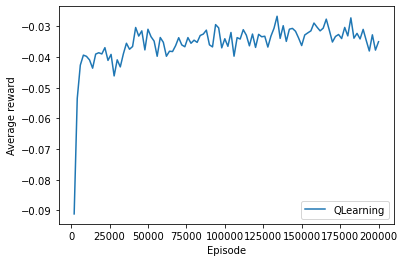

In [11]:
from gym.envs.toy_text.blackjack import BlackjackEnv


process_task(BlackjackEnv, QLearning, params)

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли
получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила
были упрощёнными, а на самом деле у игрока есть ещё и другие возможности.
Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением
ставки. Итак, у игрока появляется дополнительное действие:
* **double** — удвоить ставку; при этом больше действий делать нельзя, игроку
выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш
удваивается.


### Задание 4

Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI
Gym, в котором разрешено удвоение ставки

In [12]:
from gym import spaces


class DoubleBlackjackEnv(BlackjackEnv):
    def __init__(self, *args, **kwargs):
        super(DoubleBlackjackEnv, self).__init__(*args, **kwargs)
        
        self.action_space = spaces.Discrete(3)
        self.reset()
        
    def step(self, action):
        assert self.action_space.contains(action)
        reward = max(action, 1)
        res = list(super(DoubleBlackjackEnv, self).step(min(action, 1)))
        if action == 2 and not res[2]:
            res = list(super(DoubleBlackjackEnv, self).step(0))
        res[1] *= reward
        return res

### Задание 5

Реализуйте метод обучения с подкреплением без модели для этого варианта,
постройте графики, аналогичные п.2.


0/27
1/27
2/27
3/27
4/27
5/27
6/27
7/27
8/27
9/27
10/27
11/27
12/27
13/27
14/27
15/27
16/27
17/27
18/27
19/27
20/27
21/27
22/27
23/27
24/27
25/27
26/27
-0.0172175 {'alpha': 1e-06, 'eps': 0.9, 'gamma': 0.95}
Calculation status: 10.0 %.
Calculation status: 20.0 %.
Calculation status: 30.0 %.
Calculation status: 40.0 %.
Calculation status: 50.0 %.
Calculation status: 60.0 %.
Calculation status: 70.0 %.
Calculation status: 80.0 %.
Calculation status: 90.0 %.
Calculation status: 100.0 %.


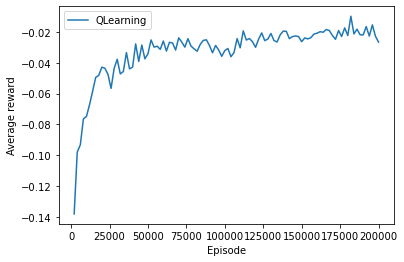

In [13]:
process_task(DoubleBlackjackEnv, QLearning, params)

## Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в
том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это
слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха
колоды до тех пор, пока карт не останется слишком мало, и только тогда колода
перемешивается; давайте для определённости считать, что наше казино будет
перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет
информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно
удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут
раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог
считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами,
так что подсчёт можно считать автоматическим.

### Задание 6

Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в
котором игрок имеет возможность “считать карты” в колоде. Это можно сделать
разными способами; возможно, вам поможет [статья википедии о блекджеке](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA) (а
возможно, и нет).

Будем считать карты в колоде по системе **половинки**:

| card | points |
|:-:   | :-:    |
| 2 | +0.5 |
| 3, 4 | +1 |
| 5 | +1.5 |
| 6 | +1 |
| 7 | +0.5 |
| 8 | 0 |
| 9 | −0,5 |
| 10, В, Д, К, Т | −1 |

In [14]:
from gym.envs.toy_text.blackjack import (
    cmp, is_bust, is_natural, score, sum_hand
)


deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4

cost = defaultdict(float)

cost.update({
    2: +0.5,
    3: +1,
    4: +1,
    5: +1.5,
    6: +1,
    7: +0.5,
    9: -0.5,
    10: -1,
})

class DoubleCountingBlackjackEnv(DoubleBlackjackEnv):
    def __init__(self, *args, **kwargs):
        self.counter = 0
        self.deck = deck.copy()
        
        super(DoubleCountingBlackjackEnv, self).__init__(*args, **kwargs)
        
    def draw_card(self):
        card = self.np_random.choice(self.deck)
        self.deck.remove(card)
        self.counter += cost[card]
        return int(card)
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
        
    def _get_obs(self):
        return (*super(DoubleCountingBlackjackEnv, self)._get_obs(), self.counter)
    
    def reset(self):
        if len(self.deck) <= 15:
            self.counter = 0
            self.deck = deck.copy()
        
        # copy-paste from original implementation because draw_card and draw_hand are not class members
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    # copy-paste from original implementation because draw_card and draw_hand are not class members
    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

### Задание 7

Реализуйте метод обучения с подкреплением без модели для этого варианта,
постройте графики, аналогичные п.2.

0/27
1/27
2/27
3/27
4/27
5/27
6/27
7/27
8/27
9/27
10/27
11/27
12/27
13/27
14/27
15/27
16/27
17/27
18/27
19/27
20/27
21/27
22/27
23/27
24/27
25/27
26/27
-0.0276775 {'alpha': 1e-05, 'eps': 0.9, 'gamma': 0.95}
Calculation status: 10.0 %.
Calculation status: 20.0 %.
Calculation status: 30.0 %.
Calculation status: 40.0 %.
Calculation status: 50.0 %.
Calculation status: 60.0 %.
Calculation status: 70.0 %.
Calculation status: 80.0 %.
Calculation status: 90.0 %.
Calculation status: 100.0 %.


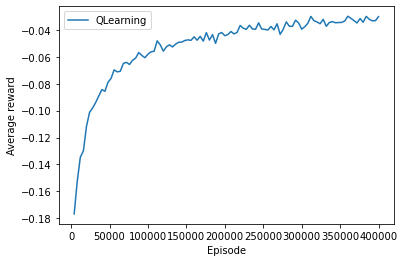

In [15]:
process_task(DoubleCountingBlackjackEnv, QLearning, params, episodes=400000)